In [42]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import yaml
from skimage import exposure, util
from skimage.transform import resize
import sklearn.model_selection
from tqdm import tqdm
import pickle
import random
from tensorflow.keras.layers import Input, Flatten, Dense, Activation, BatchNormalization, Conv2D, MaxPool2D, Softmax
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
import tensorflow_addons as tfa

Loading Data

In [43]:
data_paths = glob.glob( '../data/input/keren/*.npz')

In [44]:
# Defining cell type and channel dictionaries based off meta.yaml
with open("../data/input/keren/meta.yaml", 'r') as stream:
    data = yaml.safe_load(stream)

cell_types_dict = data['cell_types']
channels_dict = {i: j for i, j in enumerate(data['channels'])}
print(cell_types_dict)
print(channels_dict)

{0: 'Background', 1: 'Unidentified', 2: 'Endothelial', 3: 'Mesenchyme', 4: 'Tumor', 5: 'Tregs', 6: 'CD4T', 7: 'CD8T', 8: 'CD3T', 9: 'Nk', 10: 'Bcell', 11: 'Neutrophil', 12: 'Macrophage', 13: 'DC', 14: 'DC_Mono', 15: 'Mono_Neu', 16: 'Immune_other', 17: 'FAILED_HARMONIZATION'}
{0: 'Au', 1: 'B7H3', 2: 'Beta-catenin', 3: 'C', 4: 'CD11b', 5: 'CD11c', 6: 'CD138', 7: 'CD16', 8: 'CD163', 9: 'CD20', 10: 'CD209', 11: 'CD3', 12: 'CD31', 13: 'CD4', 14: 'CD45', 15: 'CD45RO', 16: 'CD56', 17: 'CD63', 18: 'CD68', 19: 'CD8', 20: 'CSF-1R', 21: 'Ca', 22: 'EGFR', 23: 'Fe', 24: 'FoxP3', 25: 'H3K27me3', 26: 'H3K9ac', 27: 'HLA-DR', 28: 'HLA-Class-1', 29: 'IDO', 30: 'Keratin17', 31: 'Keratin6', 32: 'Ki67', 33: 'Lag3', 34: 'MPO', 35: 'Na', 36: 'OX40', 37: 'P', 38: 'PDL1', 39: 'PD1', 40: 'PanCK', 41: 'SMA', 42: 'Si', 43: 'Ta', 44: 'Vimentin', 45: 'dsDNA', 46: 'p53', 47: 'pS6', 48: 'background', 49: 'sum of H3K27me3, H3K9ac, and dsDNA', 50: 'sum_PanCK_CD45'}


In [45]:
with np.load(data_paths[1], allow_pickle=True) as f:
    X = f['X']
    y = f['y']
    cell_types = f['cell_types'].item()

print(X.shape, y.shape)

(1, 2048, 2048, 51) (1, 2048, 2048, 2)


In [46]:
# Markers identified in previous notebook 
variable_markers = pd.read_pickle('../data/interim/variable_markers_df.pkl')

Utility Functions


In [76]:
def normalize_image(image):
    """
    Normalizes an image using contrast stretching.
    """
    # stretch contrast
    p2, p98 = np.percentile(image, (2, 98))
    image = exposure.rescale_intensity(image, in_range=(p2, p98))
    # rescale the image to the range [-1, 1]
    image = util.img_as_float32(image)
    return image
def select_random_cell_indices(cell_types, n=25):
    """
    Returns a list of cell indices containing 25 cells of each type.
    """
    random.seed(42)
    selected_cell_indices = []
    for value in set(cell_types.values()):
        keys = [key for key, val in cell_types.items() if val == value]
        np.random.shuffle(keys)
        selected_cell_indices.extend(keys[:n])
    return selected_cell_indices
def get_cell_views(image, cell_mask, cell_types):
    """
    Returns a list of cell views and a list of associated cell types.
    """
    cell_views = []
    cell_types_list = []
    # get random indices for 15 cells of each type cell type
    cell_type_indices = select_random_cell_indices(cell_types, n=15)
    for j in cell_type_indices:
        # mask the cell view to get only the current cell type
        masked_view = np.ma.masked_where(cell_mask != j, image)
        # append the masked view and associated cell type to the lists
        cell_views.append(masked_view)
        cell_types_list.append(cell_types[j])
    return cell_views, cell_types_list
def get_cell_boxes(image, cell_mask, cell_types, use_all_cells=False):
    """
    Returns a list of bounding boxes and a list of associated cell types.
    """
    cell_boxes = []
    cell_types_list = []
    if use_all_cells:
        cell_type_indices = list(np.unique(cell_mask))
    else:        
        # get random indices for 15 cells of each type cell type
        cell_type_indices = select_random_cell_indices(cell_types, n=30)
    # loop through cell types
    for j in cell_type_indices:
        cell_type = cell_types[j]
        # get indices for cells of current cell type
        cell_indices = np.where(cell_mask == j)
        # calculate cell center coordinates
        cell_centers = np.stack([cell_indices[0], cell_indices[1]], axis=-1)
        cell_centers = cell_centers.mean(axis=0)
        cell_center_row, cell_center_col = cell_centers.astype(int)
        # calculate cell bounding box coordinates
        bbox_row_min = max(0, cell_center_row - 10)
        bbox_row_max = min(cell_mask.shape[0]-1, cell_center_row + 10)
        bbox_col_min = max(0, cell_center_col - 10)
        bbox_col_max = min(cell_mask.shape[1]-1, cell_center_col + 10)
        # slice image to get cell view
        cell_view = image[bbox_row_min:bbox_row_max+1, bbox_col_min:bbox_col_max+1]
        # resize cell view to desired shape
        cell_view = resize(cell_view, (21, 21))
        # append the cell view and associated cell type to the lists
        cell_boxes.append(cell_view)
        cell_types_list.append(cell_type)
    return cell_boxes, cell_types_list


Normalize Image intensity using contrast stretching

In [48]:
X_norm = np.zeros_like(X)
for i in tqdm(range(X.shape[-1])):
    X_norm[..., i] = normalize_image(X[..., i])

100%|██████████| 51/51 [00:10<00:00,  4.66it/s]


Create cell views using bounding boxes

In [49]:
# Create empty arrays with the desired shape and dtype
cell_views = np.empty((len(variable_markers.index),), dtype=object)
cell_types_list = np.empty((len(variable_markers.index),), dtype=object)

for i, channel_key in enumerate(tqdm(variable_markers.index)):
    # print('Processing: ' + channels_dict[channel_key])
    cell_views[i], cell_types_list[i] = get_cell_boxes(X_norm[0,:,:,channel_key], y[0,:,:,0], cell_types)

100%|██████████| 29/29 [02:53<00:00,  5.99s/it]


Format cell views for model input

In [50]:
reshaped_cell_views = np.empty((len(cell_views), len(cell_views[0]), 21, 21))
for i, channel in enumerate(cell_views):
    reshaped_cell_views[i] = np.stack(channel)
cell_views_transposed = np.transpose(reshaped_cell_views, (1, 2, 3, 0))

reshaped_cell_types = np.empty((len(cell_types_list), len(cell_types_list[0])))
for i, channel in enumerate(cell_types_list):
    reshaped_cell_types[i] = np.stack(channel)
reshaped_cell_types = reshaped_cell_types.transpose((1, 0))

In [51]:
print(cell_views_transposed.shape, reshaped_cell_types[:,0].shape)

(443, 21, 21, 29) (443,)


Model functions

In [52]:
IMG_HEIGHT = cell_views_transposed.shape[1]
IMG_WIDTH = cell_views_transposed.shape[2]

In [53]:
# Create dataset builder
class DatasetBuilder(object):
    def __init__(self,
                 X,
                 y,
                 batch_size=1,
                 rotation_range=180,
                 scale_range=(0.75, 1.25)):
        self.X = X
        self.y = tf.keras.utils.to_categorical(y)
        
        self.batch_size = batch_size
        self.rotation_range = float(rotation_range)
        self.scale_range = scale_range
        
        # Create dataset
        self._create_dataset()
        
    def _augment(self, *args):
        img = args[0]
        label = args[1]
        
        theta = tf.random.uniform([1], 0, 2*np.pi*self.rotation_range/360)
        img = tfa.image.rotate(img, theta)
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        
        return (img, label)
        
    def _create_dataset(self):
        X_train, X_temp, y_train, y_temp = sklearn.model_selection.train_test_split(self.X, self.y, train_size=0.8)
        X_val, X_test, y_val, y_test = sklearn.model_selection.train_test_split(X_temp, y_temp, train_size=0.5)
        
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
        test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
        
        self.train_dataset = train_dataset.shuffle(256).batch(self.batch_size).map(self._augment)
        self.val_dataset = val_dataset.batch(self.batch_size)
        self.test_dataset = test_dataset.batch(self.batch_size)


# Define the convolutional neural network
def create_conv_classifier():
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, 29),
                   name='conv_classifier_input')
    x = Conv2D(64, (3,3), padding='SAME')(inputs)
    x = Activation('relu')(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPool2D(strides=(2,2))(x) # 16, 16
    x = Conv2D(64, (3,3), padding='SAME')(x)
    x = Activation('relu')(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPool2D(strides=(2,2))(x) # 8,8
    x = Conv2D(64, (3,3), padding='SAME')(x)
    x = Activation('relu')(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPool2D(strides=(2,2))(x) # 4,4
    x = Conv2D(64, (3,3), padding='SAME')(x)
    x = Activation('relu')(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPool2D(strides=(2,2))(x) # 2,2
    x = Flatten()(x)
    x = Dense(18)(x)
    x = Softmax(axis=-1)(x)
    model = Model(inputs=inputs, outputs=x)
    return model

conv_classifier = create_conv_classifier()
# plot_model(conv_classifier, show_shapes=True)

# Define the loss function
loss_function = tf.keras.losses.CategoricalCrossentropy() 
# Define training algorithm
conv_optimizer = tf.keras.optimizers.Adam(lr=1e-3, clipnorm=0.001)


In [54]:
db = DatasetBuilder(cell_views_transposed, reshaped_cell_types[:,0], batch_size=64)

In [55]:
# Define training parameters
training_steps_per_epoch=512
n_epochs=30

# Define callbacks
conv_model_path = '../data/models/conv'

conv_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        conv_model_path, monitor='val_loss',
        save_best_only=True, verbose=1,
        save_weights_only=False)
]

conv_callbacks.append(
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, verbose=1,
        patience=3, min_lr=1e-7)
)

# Define metrics
recall_0 = tf.keras.metrics.Recall(class_id=0)
recall_1 = tf.keras.metrics.Recall(class_id=1)

precision_0 = tf.keras.metrics.Precision(class_id=0)
precision_1 = tf.keras.metrics.Precision(class_id=1)

In [56]:
conv_classifier.compile(optimizer=conv_optimizer, 
                          loss=loss_function, 
                          metrics = [recall_0, recall_1, precision_0, precision_1])

Training Model

In [57]:
# Train the convolutional neural network
conv_classifier.fit(db.train_dataset,
                    validation_data=db.val_dataset,
                    epochs=n_epochs,
                    verbose=1,
                    callbacks=conv_callbacks)

Epoch 1/30


2023-04-21 15:31:21.722623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [354,18]
	 [[{{node Placeholder/_1}}]]
2023-04-21 15:31:21.722956: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [354,18]
	 [[{{node Placeholder/_1}}]]


5/6 [========================>.....] - ETA: 0s - loss: 3.5478 - recall_2: 0.0000e+00 - recall_3: 0.0000e+00 - precision_2: 0.0000e+00 - precision_3: 0.0000e+00

2023-04-21 15:31:24.170611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [44,18]
	 [[{{node Placeholder/_1}}]]



Epoch 1: val_loss improved from inf to 2.84749, saving model to ../data/models/conv


INFO:tensorflow:Assets written to: ../data/models/conv/assets


INFO:tensorflow:Assets written to: ../data/models/conv/assets


6/6 [==============================] - 5s 498ms/step - loss: 3.4645 - recall_2: 0.0000e+00 - recall_3: 0.0000e+00 - precision_2: 0.0000e+00 - precision_3: 0.0000e+00 - val_loss: 2.8475 - val_recall_2: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_precision_2: 0.0000e+00 - val_precision_3: 0.0000e+00 - lr: 0.0010
Epoch 2/30
5/6 [========================>.....] - ETA: 0s - loss: 2.1566 - recall_2: 0.0000e+00 - recall_3: 0.2857 - precision_2: 0.0000e+00 - precision_3: 1.0000     
Epoch 2: val_loss improved from 2.84749 to 2.83940, saving model to ../data/models/conv


INFO:tensorflow:Assets written to: ../data/models/conv/assets


INFO:tensorflow:Assets written to: ../data/models/conv/assets


6/6 [==============================] - 3s 631ms/step - loss: 2.1357 - recall_2: 0.0000e+00 - recall_3: 0.2857 - precision_2: 0.0000e+00 - precision_3: 1.0000 - val_loss: 2.8394 - val_recall_2: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_precision_2: 0.0000e+00 - val_precision_3: 0.0000e+00 - lr: 0.0010
Epoch 3/30
5/6 [========================>.....] - ETA: 0s - loss: 1.5844 - recall_2: 0.0000e+00 - recall_3: 0.7692 - precision_2: 0.0000e+00 - precision_3: 0.9091
Epoch 3: val_loss improved from 2.83940 to 2.80475, saving model to ../data/models/conv


INFO:tensorflow:Assets written to: ../data/models/conv/assets


INFO:tensorflow:Assets written to: ../data/models/conv/assets


6/6 [==============================] - 3s 482ms/step - loss: 1.5815 - recall_2: 0.0000e+00 - recall_3: 0.7857 - precision_2: 0.0000e+00 - precision_3: 0.8462 - val_loss: 2.8048 - val_recall_2: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_precision_2: 0.0000e+00 - val_precision_3: 0.0000e+00 - lr: 0.0010
Epoch 4/30
6/6 [==============================] - ETA: 0s - loss: 1.2714 - recall_2: 0.0000e+00 - recall_3: 0.7143 - precision_2: 0.0000e+00 - precision_3: 1.0000    
Epoch 4: val_loss improved from 2.80475 to 2.76655, saving model to ../data/models/conv


INFO:tensorflow:Assets written to: ../data/models/conv/assets


INFO:tensorflow:Assets written to: ../data/models/conv/assets


6/6 [==============================] - 2s 465ms/step - loss: 1.2714 - recall_2: 0.0000e+00 - recall_3: 0.7143 - precision_2: 0.0000e+00 - precision_3: 1.0000 - val_loss: 2.7665 - val_recall_2: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_precision_2: 0.0000e+00 - val_precision_3: 0.0000e+00 - lr: 0.0010
Epoch 5/30
5/6 [========================>.....] - ETA: 0s - loss: 1.0523 - recall_2: 0.0000e+00 - recall_3: 0.6154 - precision_2: 0.0000e+00 - precision_3: 1.0000
Epoch 5: val_loss improved from 2.76655 to 2.74703, saving model to ../data/models/conv


INFO:tensorflow:Assets written to: ../data/models/conv/assets


INFO:tensorflow:Assets written to: ../data/models/conv/assets


6/6 [==============================] - 3s 506ms/step - loss: 1.0600 - recall_2: 0.0000e+00 - recall_3: 0.6429 - precision_2: 0.0000e+00 - precision_3: 1.0000 - val_loss: 2.7470 - val_recall_2: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_precision_2: 0.0000e+00 - val_precision_3: 0.0000e+00 - lr: 0.0010
Epoch 6/30
5/6 [========================>.....] - ETA: 0s - loss: 0.8452 - recall_2: 0.0000e+00 - recall_3: 1.0000 - precision_2: 0.0000e+00 - precision_3: 0.9091
Epoch 6: val_loss improved from 2.74703 to 2.69534, saving model to ../data/models/conv


INFO:tensorflow:Assets written to: ../data/models/conv/assets


INFO:tensorflow:Assets written to: ../data/models/conv/assets


6/6 [==============================] - 2s 439ms/step - loss: 0.8790 - recall_2: 0.0000e+00 - recall_3: 0.8571 - precision_2: 0.0000e+00 - precision_3: 0.9231 - val_loss: 2.6953 - val_recall_2: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_precision_2: 0.0000e+00 - val_precision_3: 0.0000e+00 - lr: 0.0010
Epoch 7/30
5/6 [========================>.....] - ETA: 0s - loss: 0.7356 - recall_2: 0.0000e+00 - recall_3: 1.0000 - precision_2: 0.0000e+00 - precision_3: 1.0000
Epoch 7: val_loss improved from 2.69534 to 2.62141, saving model to ../data/models/conv


INFO:tensorflow:Assets written to: ../data/models/conv/assets


INFO:tensorflow:Assets written to: ../data/models/conv/assets


6/6 [==============================] - 2s 440ms/step - loss: 0.7268 - recall_2: 0.0000e+00 - recall_3: 1.0000 - precision_2: 0.0000e+00 - precision_3: 1.0000 - val_loss: 2.6214 - val_recall_2: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_precision_2: 0.0000e+00 - val_precision_3: 0.0000e+00 - lr: 0.0010
Epoch 8/30
5/6 [========================>.....] - ETA: 0s - loss: 0.6720 - recall_2: 0.0000e+00 - recall_3: 1.0000 - precision_2: 0.0000e+00 - precision_3: 1.0000
Epoch 8: val_loss improved from 2.62141 to 2.55407, saving model to ../data/models/conv


INFO:tensorflow:Assets written to: ../data/models/conv/assets


INFO:tensorflow:Assets written to: ../data/models/conv/assets


6/6 [==============================] - 2s 415ms/step - loss: 0.7004 - recall_2: 0.0000e+00 - recall_3: 0.9286 - precision_2: 0.0000e+00 - precision_3: 1.0000 - val_loss: 2.5541 - val_recall_2: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_precision_2: 0.0000e+00 - val_precision_3: 0.0000e+00 - lr: 0.0010
Epoch 9/30
6/6 [==============================] - ETA: 0s - loss: 0.5613 - recall_2: 0.0000e+00 - recall_3: 1.0000 - precision_2: 0.0000e+00 - precision_3: 0.9333
Epoch 9: val_loss improved from 2.55407 to 2.54119, saving model to ../data/models/conv


INFO:tensorflow:Assets written to: ../data/models/conv/assets


INFO:tensorflow:Assets written to: ../data/models/conv/assets


6/6 [==============================] - 2s 412ms/step - loss: 0.5613 - recall_2: 0.0000e+00 - recall_3: 1.0000 - precision_2: 0.0000e+00 - precision_3: 0.9333 - val_loss: 2.5412 - val_recall_2: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_precision_2: 0.0000e+00 - val_precision_3: 0.0000e+00 - lr: 0.0010
Epoch 10/30
5/6 [========================>.....] - ETA: 0s - loss: 0.5173 - recall_2: 0.0000e+00 - recall_3: 1.0000 - precision_2: 0.0000e+00 - precision_3: 1.0000
Epoch 10: val_loss improved from 2.54119 to 2.48466, saving model to ../data/models/conv


INFO:tensorflow:Assets written to: ../data/models/conv/assets


INFO:tensorflow:Assets written to: ../data/models/conv/assets


6/6 [==============================] - 2s 453ms/step - loss: 0.5286 - recall_2: 0.0000e+00 - recall_3: 1.0000 - precision_2: 0.0000e+00 - precision_3: 1.0000 - val_loss: 2.4847 - val_recall_2: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_precision_2: 0.0000e+00 - val_precision_3: 0.0000e+00 - lr: 0.0010
Epoch 11/30
5/6 [========================>.....] - ETA: 0s - loss: 0.4735 - recall_2: 0.0000e+00 - recall_3: 1.0000 - precision_2: 0.0000e+00 - precision_3: 0.9286
Epoch 11: val_loss improved from 2.48466 to 2.42609, saving model to ../data/models/conv


INFO:tensorflow:Assets written to: ../data/models/conv/assets


INFO:tensorflow:Assets written to: ../data/models/conv/assets


6/6 [==============================] - 2s 399ms/step - loss: 0.4887 - recall_2: 0.0000e+00 - recall_3: 1.0000 - precision_2: 0.0000e+00 - precision_3: 0.9333 - val_loss: 2.4261 - val_recall_2: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_precision_2: 0.0000e+00 - val_precision_3: 0.0000e+00 - lr: 0.0010
Epoch 12/30
5/6 [========================>.....] - ETA: 0s - loss: 0.4849 - recall_2: 0.0000e+00 - recall_3: 0.9231 - precision_2: 0.0000e+00 - precision_3: 1.0000
Epoch 12: val_loss improved from 2.42609 to 2.36119, saving model to ../data/models/conv


INFO:tensorflow:Assets written to: ../data/models/conv/assets


INFO:tensorflow:Assets written to: ../data/models/conv/assets


6/6 [==============================] - 2s 429ms/step - loss: 0.4724 - recall_2: 0.0000e+00 - recall_3: 0.9286 - precision_2: 0.0000e+00 - precision_3: 1.0000 - val_loss: 2.3612 - val_recall_2: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_precision_2: 0.0000e+00 - val_precision_3: 0.0000e+00 - lr: 0.0010
Epoch 13/30
5/6 [========================>.....] - ETA: 0s - loss: 0.4184 - recall_2: 0.0000e+00 - recall_3: 0.9091 - precision_2: 0.0000e+00 - precision_3: 0.9091     
Epoch 13: val_loss improved from 2.36119 to 2.31967, saving model to ../data/models/conv


INFO:tensorflow:Assets written to: ../data/models/conv/assets


INFO:tensorflow:Assets written to: ../data/models/conv/assets


6/6 [==============================] - 2s 460ms/step - loss: 0.4093 - recall_2: 0.0000e+00 - recall_3: 0.9286 - precision_2: 0.0000e+00 - precision_3: 0.9286 - val_loss: 2.3197 - val_recall_2: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_precision_2: 0.0000e+00 - val_precision_3: 0.0000e+00 - lr: 0.0010
Epoch 14/30
5/6 [========================>.....] - ETA: 0s - loss: 0.3459 - recall_2: 1.0000 - recall_3: 1.0000 - precision_2: 1.0000 - precision_3: 1.0000       
Epoch 14: val_loss improved from 2.31967 to 2.25308, saving model to ../data/models/conv


INFO:tensorflow:Assets written to: ../data/models/conv/assets


INFO:tensorflow:Assets written to: ../data/models/conv/assets


6/6 [==============================] - 2s 416ms/step - loss: 0.3438 - recall_2: 1.0000 - recall_3: 1.0000 - precision_2: 1.0000 - precision_3: 1.0000 - val_loss: 2.2531 - val_recall_2: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_precision_2: 0.0000e+00 - val_precision_3: 0.0000e+00 - lr: 0.0010
Epoch 15/30
5/6 [========================>.....] - ETA: 0s - loss: 0.3713 - recall_2: 0.0000e+00 - recall_3: 1.0000 - precision_2: 0.0000e+00 - precision_3: 0.9333
Epoch 15: val_loss improved from 2.25308 to 2.15212, saving model to ../data/models/conv


INFO:tensorflow:Assets written to: ../data/models/conv/assets


INFO:tensorflow:Assets written to: ../data/models/conv/assets


6/6 [==============================] - 2s 465ms/step - loss: 0.3794 - recall_2: 0.0000e+00 - recall_3: 1.0000 - precision_2: 0.0000e+00 - precision_3: 0.9333 - val_loss: 2.1521 - val_recall_2: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_precision_2: 0.0000e+00 - val_precision_3: 0.0000e+00 - lr: 0.0010
Epoch 16/30
6/6 [==============================] - ETA: 0s - loss: 0.3850 - recall_2: 0.0000e+00 - recall_3: 0.9286 - precision_2: 0.0000e+00 - precision_3: 1.0000
Epoch 16: val_loss improved from 2.15212 to 2.11945, saving model to ../data/models/conv


INFO:tensorflow:Assets written to: ../data/models/conv/assets


INFO:tensorflow:Assets written to: ../data/models/conv/assets


6/6 [==============================] - 3s 564ms/step - loss: 0.3850 - recall_2: 0.0000e+00 - recall_3: 0.9286 - precision_2: 0.0000e+00 - precision_3: 1.0000 - val_loss: 2.1194 - val_recall_2: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_precision_2: 0.0000e+00 - val_precision_3: 0.0000e+00 - lr: 0.0010
Epoch 17/30
6/6 [==============================] - ETA: 0s - loss: 0.2536 - recall_2: 1.0000 - recall_3: 1.0000 - precision_2: 1.0000 - precision_3: 1.0000     
Epoch 17: val_loss did not improve from 2.11945
6/6 [==============================] - 1s 84ms/step - loss: 0.2536 - recall_2: 1.0000 - recall_3: 1.0000 - precision_2: 1.0000 - precision_3: 1.0000 - val_loss: 2.1860 - val_recall_2: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_precision_2: 0.0000e+00 - val_precision_3: 0.0000e+00 - lr: 0.0010
Epoch 18/30
5/6 [========================>.....] - ETA: 0s - loss: 0.3041 - recall_2: 0.0000e+00 - recall_3: 1.0000 - precision_2: 0.0000e+00 - precision_3: 1.0000
Epoch 18: val_loss did not i

INFO:tensorflow:Assets written to: ../data/models/conv/assets


INFO:tensorflow:Assets written to: ../data/models/conv/assets


6/6 [==============================] - 2s 444ms/step - loss: 0.2531 - recall_2: 1.0000 - recall_3: 1.0000 - precision_2: 1.0000 - precision_3: 1.0000 - val_loss: 2.0871 - val_recall_2: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_precision_2: 0.0000e+00 - val_precision_3: 0.0000e+00 - lr: 0.0010
Epoch 20/30
5/6 [========================>.....] - ETA: 0s - loss: 0.2298 - recall_2: 0.0000e+00 - recall_3: 0.9231 - precision_2: 0.0000e+00 - precision_3: 1.0000
Epoch 20: val_loss did not improve from 2.08707
6/6 [==============================] - 0s 69ms/step - loss: 0.2357 - recall_2: 0.0000e+00 - recall_3: 0.9286 - precision_2: 0.0000e+00 - precision_3: 0.9286 - val_loss: 2.1120 - val_recall_2: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_precision_2: 0.0000e+00 - val_precision_3: 0.0000e+00 - lr: 0.0010
Epoch 21/30
6/6 [==============================] - ETA: 0s - loss: 0.1874 - recall_2: 1.0000 - recall_3: 1.0000 - precision_2: 1.0000 - precision_3: 1.0000     
Epoch 21: val_loss did not i

INFO:tensorflow:Assets written to: ../data/models/conv/assets


INFO:tensorflow:Assets written to: ../data/models/conv/assets


6/6 [==============================] - 3s 483ms/step - loss: 0.1713 - recall_2: 1.0000 - recall_3: 1.0000 - precision_2: 1.0000 - precision_3: 1.0000 - val_loss: 2.0760 - val_recall_2: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_precision_2: 0.0000e+00 - val_precision_3: 0.0000e+00 - lr: 0.0010
Epoch 23/30
6/6 [==============================] - ETA: 0s - loss: 0.1526 - recall_2: 1.0000 - recall_3: 0.9286 - precision_2: 1.0000 - precision_3: 1.0000        
Epoch 23: val_loss did not improve from 2.07595
6/6 [==============================] - 0s 76ms/step - loss: 0.1526 - recall_2: 1.0000 - recall_3: 0.9286 - precision_2: 1.0000 - precision_3: 1.0000 - val_loss: 2.1006 - val_recall_2: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_precision_2: 0.0000e+00 - val_precision_3: 0.0000e+00 - lr: 0.0010
Epoch 24/30
6/6 [==============================] - ETA: 0s - loss: 0.1638 - recall_2: 1.0000 - recall_3: 1.0000 - precision_2: 1.0000 - precision_3: 0.9333      
Epoch 24: val_loss improved from 2.

INFO:tensorflow:Assets written to: ../data/models/conv/assets


INFO:tensorflow:Assets written to: ../data/models/conv/assets


6/6 [==============================] - 2s 426ms/step - loss: 0.1638 - recall_2: 1.0000 - recall_3: 1.0000 - precision_2: 1.0000 - precision_3: 0.9333 - val_loss: 2.0147 - val_recall_2: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_precision_2: 0.0000e+00 - val_precision_3: 0.0000e+00 - lr: 0.0010
Epoch 25/30
5/6 [========================>.....] - ETA: 0s - loss: 0.1291 - recall_2: 1.0000 - recall_3: 1.0000 - precision_2: 1.0000 - precision_3: 1.0000       
Epoch 25: val_loss improved from 2.01469 to 1.96587, saving model to ../data/models/conv


INFO:tensorflow:Assets written to: ../data/models/conv/assets


INFO:tensorflow:Assets written to: ../data/models/conv/assets


6/6 [==============================] - 2s 399ms/step - loss: 0.1386 - recall_2: 1.0000 - recall_3: 1.0000 - precision_2: 1.0000 - precision_3: 1.0000 - val_loss: 1.9659 - val_recall_2: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_precision_2: 0.0000e+00 - val_precision_3: 0.0000e+00 - lr: 0.0010
Epoch 26/30
6/6 [==============================] - ETA: 0s - loss: 0.1144 - recall_2: 1.0000 - recall_3: 1.0000 - precision_2: 1.0000 - precision_3: 1.0000     
Epoch 26: val_loss improved from 1.96587 to 1.92374, saving model to ../data/models/conv


INFO:tensorflow:Assets written to: ../data/models/conv/assets


INFO:tensorflow:Assets written to: ../data/models/conv/assets


6/6 [==============================] - 3s 580ms/step - loss: 0.1144 - recall_2: 1.0000 - recall_3: 1.0000 - precision_2: 1.0000 - precision_3: 1.0000 - val_loss: 1.9237 - val_recall_2: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_precision_2: 0.0000e+00 - val_precision_3: 0.0000e+00 - lr: 0.0010
Epoch 27/30
6/6 [==============================] - ETA: 0s - loss: 0.1346 - recall_2: 1.0000 - recall_3: 1.0000 - precision_2: 1.0000 - precision_3: 1.0000     
Epoch 27: val_loss did not improve from 1.92374
6/6 [==============================] - 1s 96ms/step - loss: 0.1346 - recall_2: 1.0000 - recall_3: 1.0000 - precision_2: 1.0000 - precision_3: 1.0000 - val_loss: 1.9309 - val_recall_2: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_precision_2: 0.0000e+00 - val_precision_3: 0.0000e+00 - lr: 0.0010
Epoch 28/30
6/6 [==============================] - ETA: 0s - loss: 0.1444 - recall_2: 1.0000 - recall_3: 0.9286 - precision_2: 1.0000 - precision_3: 1.0000      
Epoch 28: val_loss improved from 1.923

INFO:tensorflow:Assets written to: ../data/models/conv/assets


INFO:tensorflow:Assets written to: ../data/models/conv/assets


6/6 [==============================] - 2s 427ms/step - loss: 0.1444 - recall_2: 1.0000 - recall_3: 0.9286 - precision_2: 1.0000 - precision_3: 1.0000 - val_loss: 1.8871 - val_recall_2: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_precision_2: 0.0000e+00 - val_precision_3: 0.0000e+00 - lr: 0.0010
Epoch 29/30
5/6 [========================>.....] - ETA: 0s - loss: 0.1363 - recall_2: 1.0000 - recall_3: 1.0000 - precision_2: 1.0000 - precision_3: 1.0000       
Epoch 29: val_loss did not improve from 1.88712
6/6 [==============================] - 1s 76ms/step - loss: 0.1451 - recall_2: 1.0000 - recall_3: 1.0000 - precision_2: 1.0000 - precision_3: 1.0000 - val_loss: 1.9049 - val_recall_2: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_precision_2: 0.0000e+00 - val_precision_3: 0.0000e+00 - lr: 0.0010
Epoch 30/30
5/6 [========================>.....] - ETA: 0s - loss: 0.0842 - recall_2: 1.0000 - recall_3: 1.0000 - precision_2: 1.0000 - precision_3: 1.0000        
Epoch 30: val_loss improved from 1

INFO:tensorflow:Assets written to: ../data/models/conv/assets


INFO:tensorflow:Assets written to: ../data/models/conv/assets


6/6 [==============================] - 2s 465ms/step - loss: 0.0826 - recall_2: 1.0000 - recall_3: 1.0000 - precision_2: 1.0000 - precision_3: 1.0000 - val_loss: 1.8675 - val_recall_2: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_precision_2: 0.0000e+00 - val_precision_3: 0.0000e+00 - lr: 0.0010


Examining Model Performance

2023-04-21 15:32:25.340513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [45,18]
	 [[{{node Placeholder/_1}}]]


2/2 [==============================] - 0s 17ms/step


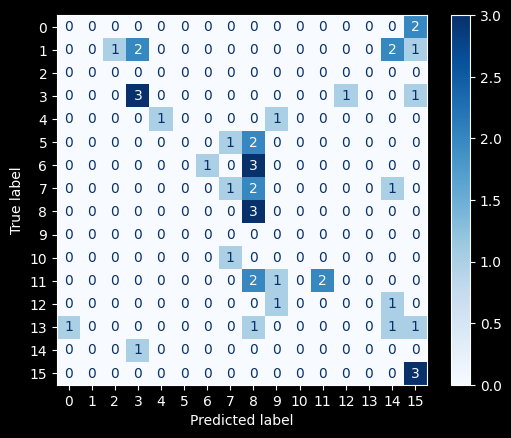

In [58]:
# Generate predictions
test_list = list(db.test_dataset.as_numpy_iterator())
X_test = [item[0] for item in test_list]
y_test = [item[1] for item in test_list]

X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)
y_test = np.argmax(y_test, axis=-1)

# Compute conv metrics
y_pred = conv_classifier.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)

confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)
cm_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot(cmap=plt.cm.Blues)
plt.show()

# cm_display.save("../figures/confusion_matrix_heatmap.png", width=6, height=6, dpi=300, facecolor='w')


# Complete Analysis Pipeline

In [ ]:
def prep_model_input(X, y, cell_types):
    # Normalize data
    X_norm = np.zeros_like(X)
    for i in tqdm(range(X.shape[-1])):
        X_norm[..., i] = normalize_image(X[..., i])
    
    # create cell views using bonding boxes
    cell_views = np.empty((len(variable_markers.index),), dtype=object)
    cell_types_list = np.empty((len(variable_markers.index),), dtype=object)
    for i, channel_key in enumerate(tqdm(variable_markers.index)):
        cell_views[i], cell_types_list[i] = get_cell_boxes(X_norm[0,:,:,channel_key], y[0,:,:,0], cell_types, use_all_cells=False)
    
    # format cell views for model input
    reshaped_cell_views = np.empty((len(cell_views), len(cell_views[0]), 21, 21))
    for i, channel in enumerate(cell_views):
        reshaped_cell_views[i] = np.stack(channel)
    cell_views_transposed = np.transpose(reshaped_cell_views, (1, 2, 3, 0))

    reshaped_cell_types = np.empty((len(cell_types_list), len(cell_types_list[0])))
    for i, channel in enumerate(cell_types_list):
        reshaped_cell_types[i] = np.stack(channel)
    reshaped_cell_types = reshaped_cell_types.transpose((1, 0))

    return cell_views_transposed, reshaped_cell_types

In [85]:
def run_pipeline(X, y, cell_types):
    cell_views, cell_types = prep_model_input(X, y, cell_types)
    # load pretrained model
    model = tf.keras.models.load_model('../data/models/conv')
    predictions = model.predict(x_test)
    return predictions

Example Model execution

In [ ]:
model_results = run_pipeline(X, y, cell_types)